In [3]:
import os

import math
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryPrecisionRecallCurve
from torchvision.transforms import v2

import timm

import numpy as np
import matplotlib.pyplot as plt


from training.hyperparameter_tuning import TLOptunaTrainer

import torch.nn.functional as F
from torchvision.utils import make_grid
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

from preprocessing.preprocessing import save_rabbit_crops

import data.custom_transforms as custom_transforms
from data.datamodule import BinaryImageDataModule
from data.datamodule import MultiClassImageDataModule

from models.model_facedetection import TransferLearningModuleMulticlass, TL_ConvNextV2

from config.load_configuration import load_configuration
config = load_configuration()

pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"       # disable oneDNN optimizations for reproducibility
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"     # otherwise matplotlib may crash

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Torch Version: ', torch.__version__)
print('Using device: ', device)
if device.type == 'cuda':
    print('Cuda Version: ', torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    torch.set_float32_matmul_precision('high')

Seed set to 42


PC Name: DESKTOP-LUKAS
Loaded configuration from config/config_lukas.yaml
Torch Version:  2.7.0+cu128
Using device:  cuda
Cuda Version:  12.8
NVIDIA GeForce RTX 5060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
base_path = "D:/HKA_IMS_Drive/"
base_path = "C:/Users/lukas/SynologyDrive_IMS/"
path_to_model = base_path + "SS25_MSYS_KAER-AI-PoseAct/21_Test_Data/Models/selected_models/FD_ConvNextV2_base_cls2_bs32_img300_optAdamW_lr3e-04_wd1e-02_sch_CosineAnnealingLR_2025-06-29_20-03.ckpt"

# Load the pretrained model from checkpoint
model = TL_ConvNextV2.load_from_checkpoint(
    path_to_model,
    amount_of_trainable_linear_layers = 2
)

eval_datamodule = MultiClassImageDataModule(
    data_dir=config['path_to_bunnie_data_aug'], 
    name_list=config['name_list'], 
    transform=v2.Compose([
        v2.Resize((300, 300)),  # Resize images to match EfficientNet input size
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
    ]),
    batch_size=config['batch_size'], 
    num_workers=2, 
    persistent_workers=True
)

eval_datamodule.setup(stage='test')
eval_loader = eval_datamodule.test_dataloader()

# Create a DataLoader for the evaluation data (real images, no normalization)
real_image_datamodule = MultiClassImageDataModule(
    data_dir=config['path_to_bunnie_data_aug'], 
    name_list=config['name_list'], 
    transform=v2.Compose([
        v2.Resize((300, 300)),  # Resize images to match EfficientNet input size
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True)        
    ]),
    batch_size=config['batch_size'], 
    num_workers=2, 
    persistent_workers=True
)
real_image_datamodule.setup(stage='test')
real_image_loader = real_image_datamodule.test_dataloader()

if False:
    #Evaluate the model
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for batch in eval_loader:
            images, labels = batch
            images = images.to(device)
            outputs = model(images)
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())
            # Uncomment the line below to evaluate on the entire dataset
            break
            
    # Concatenate results
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Example: Calculate accuracy
    accuracy = (all_outputs.argmax(dim=1) == all_labels).float().mean().item()
    print(f"Evaluation Accuracy: {accuracy:.4f}")

In [ ]:
from tqdm.notebook import tqdm

# Run inference on the test set
all_images = []
all_preds = []
all_labels = []

# You can get the total number of batches by using len(eval_loader)
total_batches = len(eval_loader)
print(f"Total batches: {total_batches}")

model.eval()
with torch.no_grad():
    for batch in tqdm(real_image_loader, total=total_batches, desc="Inference (real images)"):
        batch_images, batch_labels = batch
        batch_images = batch_images.to(device)

        # Apply normalization after loading the batch
        norm = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        normed_images = norm(batch_images)

        # Get model predictions
        outputs = model(normed_images)
        predictions = torch.argmax(outputs, dim=1)

        # Store results
        all_images.append(batch_images.cpu())
        all_preds.append(predictions.cpu())
        all_labels.append(batch_labels.cpu())

# Concatenate all batches
images = torch.cat(all_images, dim=0)
preds = torch.cat(all_preds, dim=0)
labels = torch.argmax(torch.cat(all_labels, dim=0), dim=1)

# print("preds:", preds)
# print("labels:", labels)

print(f"Total images: {len(images)}")
print(f"Accuracy: {(preds == labels).float().mean():.4f}")

Total batches: 13


Inference (real images):   0%|          | 0/13 [00:00<?, ?it/s]

images: [tensor([[[[0.3412, 0.3255, 0.3216,  ..., 0.3137, 0.3059, 0.2980],
          [0.3333, 0.3255, 0.3294,  ..., 0.3098, 0.3020, 0.2902],
          [0.3294, 0.3294, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
          ...,
          [0.4824, 0.4745, 0.4667,  ..., 0.8588, 0.8667, 0.8667],
          [0.4824, 0.4745, 0.4706,  ..., 0.8510, 0.8588, 0.8588],
          [0.4863, 0.4824, 0.4824,  ..., 0.8392, 0.8431, 0.8471]],

         [[0.2745, 0.2588, 0.2549,  ..., 0.3020, 0.3020, 0.2941],
          [0.2667, 0.2588, 0.2627,  ..., 0.2980, 0.2941, 0.2863],
          [0.2627, 0.2627, 0.2588,  ..., 0.2902, 0.2863, 0.2784],
          ...,
          [0.4157, 0.4078, 0.4000,  ..., 0.6784, 0.6863, 0.6902],
          [0.4157, 0.4078, 0.4039,  ..., 0.6706, 0.6784, 0.6824],
          [0.4196, 0.4157, 0.4157,  ..., 0.6588, 0.6627, 0.6667]],

         [[0.1961, 0.1804, 0.1765,  ..., 0.3294, 0.3216, 0.3137],
          [0.1882, 0.1804, 0.1843,  ..., 0.3255, 0.3176, 0.3059],
          [0.1843, 0.1843, 0.1843

In [ ]:
def show_page_with_predictions(page_idx, images_per_page=8):
    start_idx = page_idx * images_per_page
    end_idx = min(start_idx + images_per_page, len(images))
    
    page_images = images[start_idx:end_idx]
    page_preds = preds[start_idx:end_idx]
    page_labels = labels[start_idx:end_idx]
    
    # Add colored padding: red for 0, green for 1
    padded_images = []
    pad_size = 4
    
    for img, pred, label in zip(page_images, page_preds, page_labels):
        # Green border if correct, red if incorrect
        is_correct = pred == label
        color = torch.tensor([0, 1, 0]) if is_correct else torch.tensor([1, 0, 0])  # RGB
        color = color.view(3, 1, 1).type_as(img.cpu())

        # Create background with padding
        bg = color.expand(3, img.shape[1] + 2*pad_size, img.shape[2] + 2*pad_size).clone()
        bg[:, pad_size:-pad_size, pad_size:-pad_size] = img.cpu()
        padded_images.append(bg)
    
    # Create grid with 2 rows and 4 columns
    grid = make_grid(padded_images, nrow=4, padding=2)
    
    # Display
    plt.figure(figsize=(12, 6))  # Reduced height since we have fewer rows
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(f"Page {page_idx + 1} - Green border = Correct Prediciton, Red border = Incorrect Prediction")
    
    # Add text annotations for each image
    for i, (pred, label) in enumerate(zip(page_preds, page_labels)):
        row = i // 4
        col = i % 4
        plt.text(col * (grid.shape[2] // 4) + (grid.shape[2] // 8), 
                row * (grid.shape[1] // 2) + 20,  # Changed from //4 to //2 for 2 rows
                f"P:{int(pred)} T:{int(label)}", 
                fontsize=8, color='white', weight='bold',
                ha='center', bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary for this page
    correct = sum(1 for p, l in zip(page_preds, page_labels) if int(p) == int(l))
    print(f"Page {page_idx + 1}: {correct}/{len(page_preds)} correct predictions")

# Calculate total pages
images_per_page = 8  # Changed from 16 to 8
total_pages = (len(images) + images_per_page - 1) // images_per_page

# Create navigation widgets
page_slider = widgets.IntSlider(
    min=0, 
    max=total_pages - 1, 
    step=1, 
    description='Page:',
    value=0,
    style={'description_width': 'initial'}
)

prev_button = widgets.Button(description="◀ Previous")
next_button = widgets.Button(description="Next ▶")
page_info = widgets.HTML(value=f"Page 1 of {total_pages}")

output = widgets.Output()

def update_page_info():
    current_page = page_slider.value + 1
    page_info.value = f"Page {current_page} of {total_pages}"

def on_page_change(change):
    with output:
        clear_output(wait=True)
        show_page_with_predictions(change['new'])
    update_page_info()

def on_prev_click(b):
    if page_slider.value > 0:
        page_slider.value -= 1

def on_next_click(b):
    if page_slider.value < total_pages - 1:
        page_slider.value += 1

# Connect event handlers
page_slider.observe(on_page_change, names='value')
prev_button.on_click(on_prev_click)
next_button.on_click(on_next_click)

# Create layout
nav_box = widgets.HBox([prev_button, page_slider, next_button, page_info])
full_widget = widgets.VBox([nav_box, output])

# Display the widget
display(full_widget)

# Show initial page
update_page_info()
with output:
    show_page_with_predictions(0)

## Single Image Processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


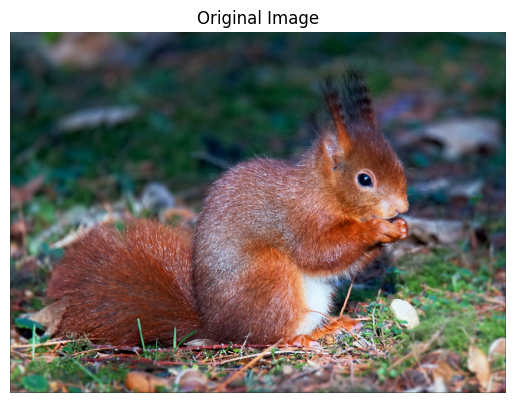

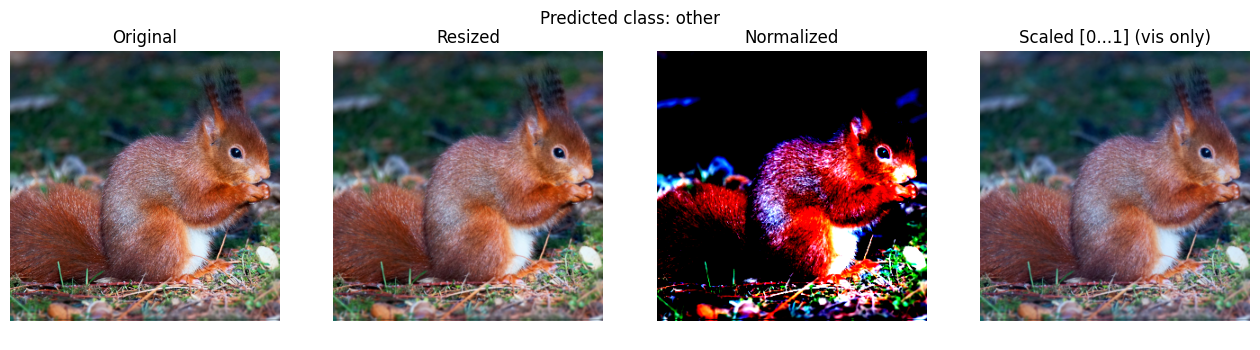

In [7]:
from PIL import Image
import os

# Path to the image you want to predict
single_image_path = r"F:\Users\Mika\Documents\Studium_HKA\Semester2\HKA_VDKI\Mika_Data\ApolloSelene\Sources\IMG_7049.JPEG"  # Change this to your image path
single_image_path = r"C:\Users\lukas\SynologyDrive_IMS\SS25_MSYS_KAER-AI-PoseAct\21_Test_Data\dataset_aufgabe1_raw\02_Kein_Kaninchen\Eichhoernchen_0004_nok.jpg"

# Check if the path is a file or a directory and create a list of files accordingly
if os.path.isfile(single_image_path):
    files = [single_image_path]
elif os.path.isdir(single_image_path):
    # Collect all image files in the directory (common image extensions)
    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    files = [os.path.join(single_image_path, f) for f in os.listdir(single_image_path) if f.lower().endswith(exts)]
else:
    files = []
    print(f"Path does not exist: {single_image_path}")

transform = v2.Compose([
    v2.Resize((300, 300)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])
plt.imshow(Image.open(single_image_path))
plt.title("Original Image")
plt.axis('off')

# Run prediction
model.eval()
model.to(device)

for file in files:
    images = save_rabbit_crops(file)
    for img in images:
        with torch.no_grad():
            output = model(transform(img).unsqueeze(0).to(device))  # Add batch dimension
            pred_class = torch.argmax(output, dim=1).item()

        # Visualize the effect of the transformation (before normalization)
        plt.figure(figsize=(16,4))
        plt.title(f"Predicted class: {config['name_list'][pred_class]}")
        plt.axis('off')

        plt.subplot(1,4,1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        img_resized = v2.Resize((300, 300))(img)
        plt.subplot(1,4,2)
        plt.imshow(img_resized)
        plt.title("Resized")
        plt.axis('off')
        
        img_tensor = v2.ToImage()(img_resized)
        img_tensor = v2.ToDtype(torch.float32, scale=True)(img_tensor)  # Convert to float32 and scale
        img_tensor_normalized = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
        img_normalized = img_tensor_normalized.permute(1, 2, 0).cpu().numpy()
        plt.subplot(1,4,3)
        plt.imshow(img_normalized)
        plt.title("Normalized")
        plt.axis('off')

        img_normalized_vis = (img_normalized - img_normalized.min()) / (img_normalized.max() - img_normalized.min())
        plt.subplot(1,4,4)
        plt.imshow(img_normalized_vis)
        plt.title("Scaled [0...1] (vis only)")
        plt.axis('off')
        
        plt.show()